# Lithology classification

## Data

This notebook uses data from the [Upper Condamine Catchment](http://www.bom.gov.au/qld/flood/brochures/condamine_balonne/map_upper.shtml) in the state of Queensland. The data is sourced from personal communication as a project output. It may be shared publicly and downloadable from this sample notebook in the future.

![Upper Condamine catchment formations](img/Upper_Condamine_formations.png "Upper Condamine catchment formations")

(Figure from [this paper](https://www.researchgate.net/figure/Upper-Condamine-catchment-Queensland-Australia-The-Marburg-Subgroup-consists-of_fig1_283184727))

## Status

As of May 2019 this present document is an output from exploratory work done during an internship by [Sudhir Gupta](https://github.com/Sudhir22).


## Purpose

This notebook compares the performance of two techniques for semi-automated classification . It also summarise work using ontologies for classification for cases where we do not have reliable training sets.


## Importing python packages

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd


In [2]:
# Only True for co-dev of ela from this use case:
ela_from_source = False
ela_from_source = True

In [3]:
if ela_from_source:
    if ('ELA_SRC' in os.environ):
        root_src_dir = os.environ['ELA_SRC']
    elif sys.platform == 'win32':
        root_src_dir = r'C:\src\github_jm\pyela'
    else:
        username = os.environ['USER']
        root_src_dir = os.path.join('/home', username, 'src/github_jm/pyela')
    pkg_src_dir = root_src_dir
    sys.path.append(pkg_src_dir)

from ela.textproc import *
from ela.utils import *
from ela.classification import *
from ela.visual import *

In [4]:
import striplog
from striplog import Lexicon

In [5]:
if ('ELA_DATA' in os.environ):
    data_path = os.environ['ELA_DATA']
elif sys.platform == 'win32':
    data_path = r'C:\data\Lithology'
else:
    username = os.environ['USER']
    data_path = os.path.join('/home', username, 'data', 'Lithology')

condamine_litho_dir = os.path.join(data_path,'Condamine')
condamine_litho_xl = os.path.join(condamine_litho_dir, 'MASTER_CONDAMINE_Interpretation_all_combined_Jan2017.xlsx')

# Exploring the lithology

In [6]:
train_data=pd.read_excel(condamine_litho_xl)

In [7]:
train_data_unprocessed = train_data.copy()

In [8]:
train_data['Simplified_lithology'] = train_data['Simplified_lithology'].replace(np.nan,'',regex=True)
train_data['Simplified_lithology'] = train_data['Simplified_lithology'].str.lower()

In [9]:
df = train_data
LITHO_DESC_COL='Lithology_original'

In [10]:
descs = df[LITHO_DESC_COL]
descs = descs.reset_index()
descs[LITHO_DESC_COL] = descs[LITHO_DESC_COL].replace(np.nan,'',regex=True)
descs[LITHO_DESC_COL] = descs[LITHO_DESC_COL].str.lower()

descs = descs[LITHO_DESC_COL]
descs.head()

0                  brown clay
1    brown clay and pipe clay
2             white pipe clay
3               red pipe clay
4               clay and sand
Name: Lithology_original, dtype: object

In [11]:
lex = Lexicon.default()
expanded_descs = descs.apply(lex.expand_abbreviations)
y = expanded_descs.values

In [12]:
y = v_lower(y)

In [13]:
def flat_list_tokens(y):
    vt = v_word_tokenize(y)
    flat = np.concatenate(vt)
    stoplist = stopwords.words('english')
    exclude = stoplist + ['.',',',';',':','(',')','-']
    flat = [word for word in flat if word not in exclude]
    return flat

In [14]:
flat = flat_list_tokens(y)
len(set(flat))

18821

In [15]:
y = v_split_with_term(y)

In [16]:
flat = flat_list_tokens(y)
len(set(flat))

18567

In [17]:
df_most_common= token_freq(flat, 50)

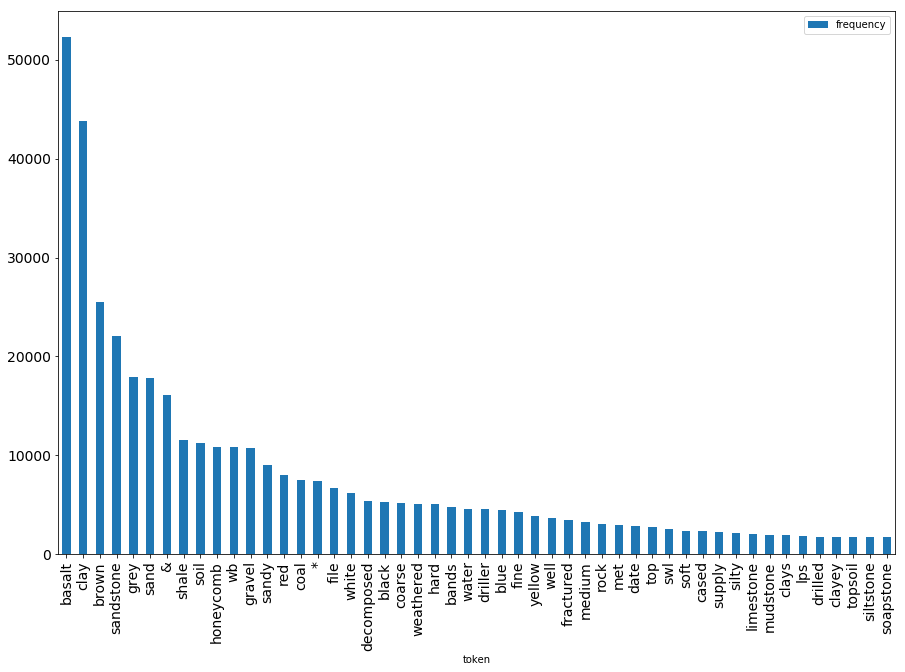

In [18]:
plot_freq(df_most_common)

# Defining lithology classes

In [19]:
lithologies = ['basalt', 'clay', 'sand','sandstone','shale','soil','honeycomb','gravel','coal','gravel','silt','soil','rock']

In [20]:
any_litho_markers_re = r'sand|clay|ston|shale|basalt|silt|soil|gravel|rock|mud|calca|calci'
regex = re.compile(any_litho_markers_re)

lithologies_dict = dict([(x,x) for x in lithologies])
lithologies_dict['sands'] = 'sand'
lithologies_dict['clays'] = 'clay'
lithologies_dict['shales'] = 'shale'
lithologies_dict['claystone'] = 'clay'
lithologies_dict['siltstone'] = 'silt'
lithologies_dict['limesand'] = 'sand' # ??
lithologies_dict['calcarenite'] = 'limestone' # ??
lithologies_dict['calcitareous'] = 'limestone' # ??
lithologies_dict['mudstone'] = 'silt' # ??
lithologies_dict['capstone'] = 'limestone' # ??
lithologies_dict['ironstone'] = 'sandstone' # ??
lithologies_dict['topsoil'] = 'soil' # ??

In [21]:
lithologies_adjective_dict = {
    'sandy' :  'sand',
    'clayey' :  'clay',
    'clayish' :  'clay',
    'shaley' :  'shale',
    'silty' :  'silt',
    'gravelly' :  'gravel'
}

In [22]:
t = y 

In [23]:
v_tokens = v_word_tokenize(t)
vt = v_find_litho_markers(v_tokens, regex=regex)

In [24]:
zero_mark = len([x for x in vt if len(x) == 0 ])
at_least_one_mark = len([x for x in vt if len(x) >= 1])
at_least_two_mark = len([x for x in vt if len(x) >= 2])
print('There are %s entries with no marker, %s entries with at least one, %s with at least two'%(zero_mark,at_least_one_mark,at_least_two_mark))

There are 10536 entries with no marker, 167096 entries with at least one, 32067 with at least two


# Testing the regular expression model on the Condamine dataset

In [25]:
prim_litho = [find_primary_lithology(x, lithologies_dict) for x in vt]

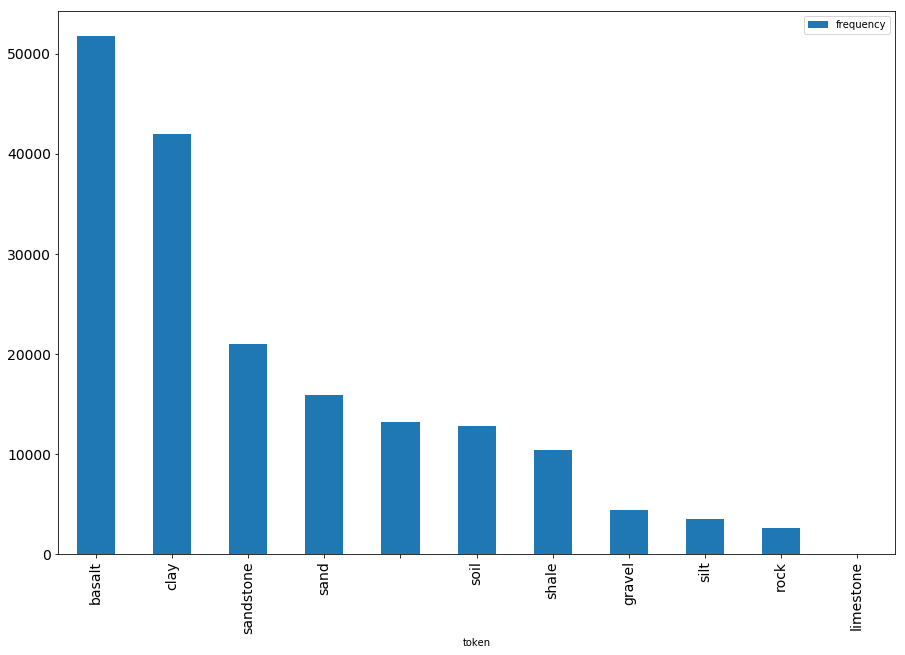

In [26]:
n = len(set(prim_litho))
plot_freq(token_freq(prim_litho, n_most_common = n))

In [27]:
lithology_map={
    'basalt' :  'basalt',
    'clay' :  'bedrock',
    'sandstone' :  'bedrock',
    'sand' :  'alluvium',
    '' :  'unknown',
    'soil' :  'alluvium',
    'shale': 'bedrock',
    'gravel': 'alluvium',
    'silt' : 'bedrock',
    'rock' : 'bedrock',
    'limestone' : 'alluvium'
}


In [28]:
final_prim_litho=list()
for x in prim_litho:
    final_prim_litho.append(lithology_map[x])

In [29]:
simplified_lithology=train_data['Simplified_lithology'].tolist()
count=0
for i in range(0,len(final_prim_litho)):
    if final_prim_litho[i].lower()==simplified_lithology[i].lower():
        count=count+1

print("Accuracy of regex for classifying primary lithologies: ", (count/len(final_prim_litho)))
        

Accuracy of regex for classifying primary lithologies:  0.6638668708340839


# Testing the deep learning model on the same dataset

In [30]:
train_data=train_data_unprocessed.copy()

In [42]:
# conda install gensim
# conda install tensorflow
# conda install keras
# pip install wordcloud

from ela.experiment.textproc import Model

In [46]:
model=Model(train_data,20)

In [47]:
model.initialise_model()

    RN                  Type   EASTING   NORTHING        Lithology_original  \
0  202  new_bedrock_addition  385411.0  7014147.0                BROWN CLAY   
1  202  new_bedrock_addition  385411.0  7014147.0  BROWN CLAY AND PIPE CLAY   
2  202  new_bedrock_addition  385411.0  7014147.0           WHITE PIPE CLAY   
3  202  new_bedrock_addition  385411.0  7014147.0             RED PIPE CLAY   
4  202  new_bedrock_addition  385411.0  7014147.0             CLAY AND SAND   

  Simplified_lithology Simplified_lithology_stratigraphy   From     To  
0              BEDROCK                           BEDROCK   0.00  10.67  
1              BEDROCK                           BEDROCK  10.67  24.38  
2              BEDROCK                           BEDROCK  24.38  26.82  
3              BEDROCK                           BEDROCK  26.82  31.70  
4              BEDROCK                           BEDROCK  31.70  50.90  
Instructions for updating:
Colocations handled automatically by placer.
Instructions fo

Deep Learning model gives us an accuracy of 87%

# Checking the accuracy if geolocation and log descriptions are taken as input features 

Logistic Regression for classifying lithologies based on geolocation. Combining the outputs of the logistic regression model and the deep learning model.

In [48]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [55]:
train_data = train_data_unprocessed.copy()
set(train_data['Simplified_lithology'].values)

{'ALLUVIUM',
 'Alluvium',
 'BASEMENT',
 'BEDROCK',
 'Basalt',
 'Basement',
 'Diorite',
 'GRAVEL',
 'Granite',
 'Granodiorite',
 'TERTIARY',
 'Unknown',
 'WEATHERING_HORIZON',
 'Wrong_location'}

In [56]:
train_data['Simplified_lithology']=train_data['Simplified_lithology'].replace(np.nan,'Unknown',regex=True)

In [57]:
train_data['Simplified_lithology']=train_data['Simplified_lithology'].str.lower()

In [58]:
set(train_data['Simplified_lithology'].values)

{'alluvium',
 'basalt',
 'basement',
 'bedrock',
 'diorite',
 'granite',
 'granodiorite',
 'gravel',
 'tertiary',
 'unknown',
 'weathering_horizon',
 'wrong_location'}

In [59]:
train_data['Simplified_lithology'],labels=pd.factorize(train_data['Simplified_lithology'])

In [60]:
train_X=train_data[['EASTING','NORTHING']][0:len(model.train_X)]
test_X=train_data[['EASTING','NORTHING']][len(model.train_X):]
train_y=train_data['Simplified_lithology'][0:len(model.train_X)]
test_y=train_data['Simplified_lithology'][len(model.train_X):]
train_X.replace(np.nan,0.0,inplace=True)
test_X.replace(np.nan,0.0,inplace=True)
print(train_X.shape)
print(train_y.shape)


(133086, 2)
(133086,)


In [61]:
clf=LogisticRegression(C=0.01)

In [62]:
clf.fit(train_X,train_y)

/home/per202/anaconda3/envs/ELA/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/per202/anaconda3/envs/ELA/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [63]:
y_pred=clf.predict_proba(test_X)

In [64]:
from sklearn.metrics import accuracy_score

In [71]:
train_data=train_data_unprocessed.copy()
new_df=pd.DataFrame(train_data[['Lithology_original']].values,columns=['Description'])

In [72]:
new_df.head()

,Description
0,BROWN CLAY
1,BROWN CLAY AND PIPE CLAY
2,WHITE PIPE CLAY
3,RED PIPE CLAY
4,CLAY AND SAND


In [75]:
new_df = new_df[len(model.train_X):].copy()

In [76]:
y_pred_dl=model.predict_certainity(new_df)

[[6.8355858e-04 1.2913742e-04 1.6483096e-04 ... 2.1094961e-07
  2.8673277e-09 4.9430048e-07]
 [2.6318573e-03 5.3469115e-04 5.4568669e-04 ... 6.6122141e-07
  7.0812298e-09 9.6469626e-07]
 [6.8355858e-04 1.2913742e-04 1.6483096e-04 ... 2.1094961e-07
  2.8673277e-09 4.9430048e-07]
 ...
 [4.6578220e-01 4.1417226e-01 4.3954011e-02 ... 2.3565799e-07
  9.5577980e-06 2.0484165e-05]
 [6.2930319e-03 9.8790097e-01 4.8819133e-03 ... 6.6473362e-08
  1.5511291e-07 1.6838335e-06]
 [6.2930319e-03 9.8790097e-01 4.8819133e-03 ... 6.6473362e-08
  1.5511291e-07 1.6838335e-06]]


In [77]:
y_pred, y_pred_dl

(array([[1.31672294e-01, 1.31672294e-01, 1.31672294e-01, ...,
         1.66970207e-02, 1.31672267e-01, 1.60941238e-02],
        [1.31672294e-01, 1.31672294e-01, 1.31672294e-01, ...,
         1.66970207e-02, 1.31672267e-01, 1.60941238e-02],
        [1.31672294e-01, 1.31672294e-01, 1.31672294e-01, ...,
         1.66970207e-02, 1.31672267e-01, 1.60941238e-02],
        ...,
        [2.62454152e-01, 1.94781857e-01, 1.67760427e-02, ...,
         2.98105056e-05, 1.53391350e-04, 7.54628973e-06],
        [2.14690598e-01, 1.13712118e-01, 1.40519870e-02, ...,
         2.45216722e-05, 3.18696480e-04, 6.33919774e-06],
        [2.82177649e-01, 2.35644819e-01, 1.80119130e-02, ...,
         3.24584013e-05, 1.17950142e-04, 8.17254134e-06]]), None)

In [78]:
print(y_pred.shape)
print(y_pred_dl.shape)

(44546, 11)


AttributeError: 'NoneType' object has no attribute 'shape'

In [79]:
final_class_prob=np.mean(np.array([y_pred,y_pred_dl]), axis=0 )

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [80]:
print(final_class_prob.shape)

NameError: name 'final_class_prob' is not defined

In [81]:
final_output_numerical=np.argmax(final_class_prob,axis=1)

NameError: name 'final_class_prob' is not defined

In [82]:
print(accuracy_score(test_y,final_output_numerical))

NameError: name 'final_output_numerical' is not defined

In [83]:
simplified_lithology_categories=[]
for x in final_output_numerical:
    simplified_lithology_categories.append(labels[x])

NameError: name 'final_output_numerical' is not defined

It does not increase the accuracy. Don't think the geolocation has an impact on the simplified lithologies

### Comparing visually

Optional

## Observations and discussions

Explaining if possible why DL so much better

## Conclusion and future work